In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# NOTE: I am ignoring the deprecation warnings on lmafit because I haven't found a way around them yet
warnings.filterwarnings("ignore")

cwd = os.getcwd()
par = os.path.join(cwd, os.pardir)
sys.path.append(par)

# I made some modules to make importing easier and to have a nice class
# that does all the matrix operations
import matrix_operation
import Dataset

In [2]:
# Just to reload the modules I imported above so I dont need to restart the kernel after making changes
import importlib
importlib.reload(matrix_operation)
importlib.reload(Dataset)

from matrix_operation import mat_opr
from Dataset import dataset

### Import and combine NYT and Big10

In [3]:
# hopefully this works on with your directory structure
# dset.nyt_df : NYT data
# dset.big10_df : Big10 data
# dset.combined and dset.dataframe are the combined version
dset = dataset()

# drop all zero rows
dset.drop_zero_rows()
dset.drop_zero_cols()

### Check the SVD to see whats going on with the rank:

In [4]:
np.linalg.matrix_rank(dset.array)

27

104 singular values (the matrix is 104 x 1872)


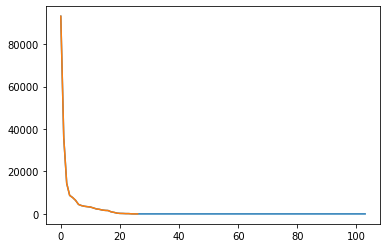

In [5]:
u, s, vt  = np.linalg.svd(dset.array)
print(str(s.shape[0]) + " singular values (the matrix is 104 x 1872)")
plt.plot(range(len(s)),s)

# The first 28 values are the only ones that aren't tiny numbers -- effective rank of 28?

plt.plot(range(27),s[:27])

#print(s[:28])

### Calculate rank approximation 

In [6]:
def rank_approx(data_obj):
    u,s,vt = np.linalg.svd(dset.array)
    denom = 0
    for i in s:
        denom += i**2

    numer = 0
    ratio = 0
    ranker = 0
    while ratio < 0.8:
        ratio = (numer + s[ranker]**2)/denom
        ranker += 1

    print("rank approx: " + str(ranker))
    return ranker

In [7]:
ranker = rank_approx(dset)

rank approx: 1


## Compare inputs and output after lmafit + isotonic regression

In [8]:
inp = dset.dataframe

# Matrix completion
X,Y,oth = dset.lmafitter(rank = ranker, val = 0)
comp = pd.DataFrame(np.dot(X,Y))

pre_iso = comp
pre_iso.columns = inp.columns
pre_iso.index = inp.index

# Isotonic regression
comp = mat_opr(comp)
iso = comp.known_iso()
out = iso.dataframe

### Big 10 Schools

<AxesSubplot:title={'center':'University of Iowa'}>

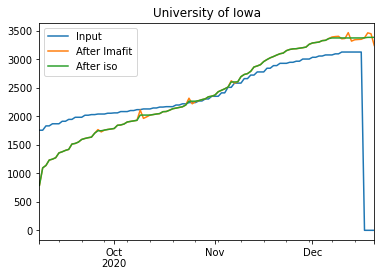

In [9]:
Iowa = pd.concat([inp['Iowa'], pre_iso['Iowa'], out['Iowa']], axis = 1)
Iowa.columns = ['Input', 'After lmafit', 'After iso']

Iowa.plot(legend=True, title = "University of Iowa")

<AxesSubplot:title={'center':'Michigan State'}>

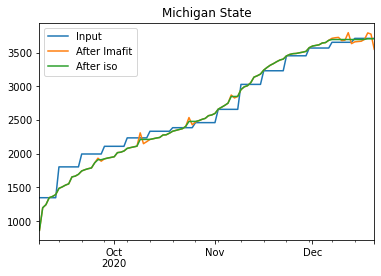

In [10]:
Michigan = pd.concat([inp['Michigan State'], pre_iso['Michigan State'], out['Michigan State']], axis = 1)
Michigan.columns = ['Input', 'After lmafit', 'After iso']

Michigan.plot(legend=True, title = "Michigan State")

<AxesSubplot:title={'center':'Ohio State'}>

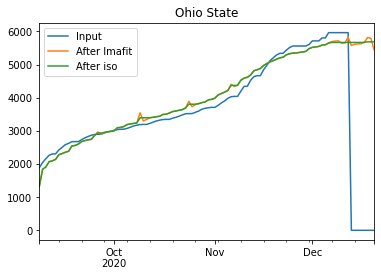

In [11]:
Ohio = pd.concat([inp['Ohio State'], pre_iso['Ohio State'], out['Ohio State']], axis = 1)
Ohio.columns = ['Input', 'After lmafit', 'After iso']

Ohio.plot(legend=True, title="Ohio State")

### NYT Schools

<AxesSubplot:title={'center':'Boston University'}>

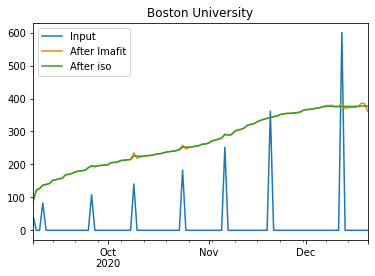

In [12]:
bu = pd.concat([inp['Boston University'], pre_iso['Boston University'], out['Boston University']], axis = 1)
bu.columns = ['Input', 'After lmafit', 'After iso']

bu.plot(legend=True, title = 'Boston University')

<AxesSubplot:title={'center':'University of California, Los Angeles'}>

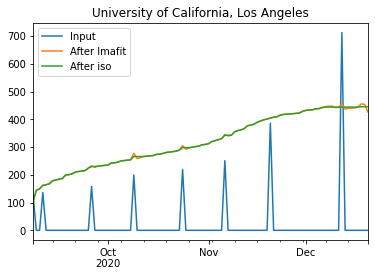

In [13]:
ucla = pd.concat([inp['University of California, Los Angeles'], pre_iso['University of California, Los Angeles'], out['University of California, Los Angeles']], axis = 1)
ucla.columns = ['Input', 'After lmafit', 'After iso']

ucla.plot(legend=True, title = 'University of California, Los Angeles')

<AxesSubplot:title={'center':'Florida State University'}>

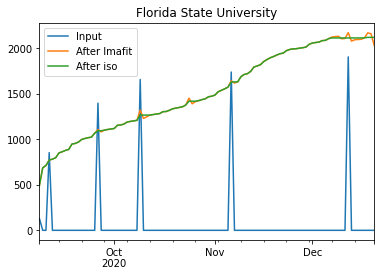

In [14]:
florida = pd.concat([inp['Florida State University'], pre_iso['Florida State University'], out['Florida State University']], axis = 1)
florida.columns = ['Input', 'After lmafit', 'After iso']

florida.plot(legend=True, title = 'Florida State University')

In [15]:
dset.rank_approx()

1

### Randomly Hide entries and compute error

In [16]:
def error(hidden_vals, newframe):
    # hidden_vals is a dictionary with structure {(x,y): value}
    # new frame is the dataframe after doing matrix completion etc.
    
    # Keeping things simple by doing mean absolute error for now
    summ = 0
    for h in hidden_vals.keys():
        frame_val = newframe.iloc[h[0],h[1]]
        if frame_val is None or np.isnan(frame_val):
            frame_val = 0
        err = abs(frame_val - hidden_vals[h])
        summ += err
        
    mean_absolute = summ/len(hidden_vals)
    
    #print("The computed matrix has an average error of " + str(mean_absolute))
    #print()
    return mean_absolute
        
        

In [17]:
def hider(obj, trials = [], isotonic = False):
    # trials should be a list of percents [0.33, 0.25, ...] corresponding to how much data is hidden
    trials.sort()
    
    results = []
    for i in trials:
        # Make the new hidden matrix and record the values that were hidden
        hidden_matrix, hidden_values = obj.hide_entries(i, 0)
        
        # Do lmafit
        X,Y,other = hidden_matrix.lmafitter(rank = ranker, val = 0)
        complete = pd.DataFrame(np.dot(X,Y))
        
        #print("With " + str(i) + " percent hidden: ")
        #hidden_matrix.is_col_inc()
        
        # Optional: do isotonic regression
        if isotonic == True:
            iso_reg = mat_opr(complete).known_iso()
            results.append(error(hidden_values, iso_reg.dataframe))
        else:
            results.append(error(hidden_values, complete))
            
    return results
        

In [18]:
tests = np.linspace(0.1,1,10)

{0.1: 57.14326390638713, 0.2: 59.30775663556926, 0.30000000000000004: 60.357651802034596, 0.4: 60.56166478437179, 0.5: 68.41476260154488, 0.6: 73.25981028892538, 0.7000000000000001: 86.50462447823861, 0.8: 115.83335125216077, 0.9: 186.63154813499264, 1.0: 400.9463193027999}


Text(0.5, 1.0, 'Error after matrix completion')

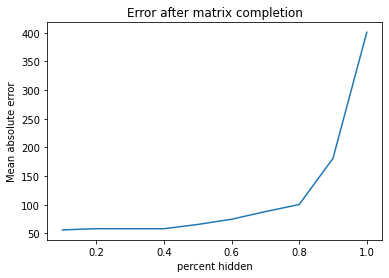

In [19]:
# These tests take a while
final_err = [0 for i in range(len(tests))]

# average over 5 trials
for i in range(5):
    errors = hider(dset, tests)
    for j in range(len(errors)):
        final_err[j] += errors[j]
    
final_err = [i/5 for i in final_err]
print({tests[i]:final_err[i] for i in range(len(tests))})
    
    
plt.plot(tests, errors)
plt.xlabel("percent hidden")
plt.ylabel("Mean absolute error")
plt.title("Error after matrix completion")

{0.1: 57.020589816681436, 0.2: 58.88633176839401, 0.30000000000000004: 59.345060027794986, 0.4: 60.39872404198727, 0.5: 62.425400519300624, 0.6: 67.51360286294153, 0.7000000000000001: 74.9719018102367, 0.8: 96.56652500686734, 0.9: 122.0935173461392, 1.0: 400.9463193027999}


Text(0.5, 1.0, 'Error after matrix completion + isotonic regression')

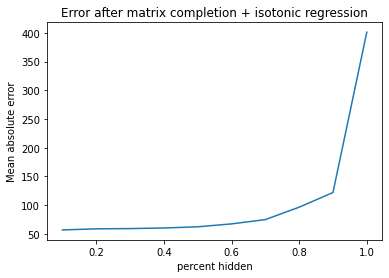

In [20]:
# with isotonic regression:
final_err = [0 for i in range(len(tests))]

# average over 5 trials
for i in range(5):
    errors = hider(dset, tests, True)
    for j in range(len(errors)):
        final_err[j] += errors[j]
    
final_err = [i/5 for i in final_err]
print({tests[i]:final_err[i] for i in range(len(tests))})

plt.plot(tests, final_err)
plt.xlabel("percent hidden")
plt.ylabel("Mean absolute error")
plt.title("Error after matrix completion + isotonic regression")

## Experiment 1 -- Monotonicity 

In [21]:
# Check if the initial matrix is column increasing
# NOTE: this does not include points that are 0 or None
violation_dict, percent = dset.is_col_inc()
print(str(percent) + ' percent of the data points are non-increasing')

0.06523257725180802 percent of the data points are non-increasing


In [22]:
# do isotonic regression on the original matrix:
with_iso = dset.known_iso()

In [23]:
with_iso.rank_approx()

1

In [24]:
np.linalg.matrix_rank(with_iso.array)

39

In [25]:
# run lmafit
X2, Y2, o2 = with_iso.lmafitter()

dotted = pd.DataFrame(np.dot(X2, Y2))
dotted.columns = dset.dataframe.columns
dotted.index = dset.dataframe.index
with_comp = mat_opr(dotted)

<AxesSubplot:title={'center':'University of Iowa'}>

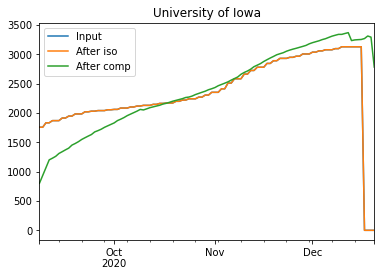

In [26]:
Iowa = pd.concat([dset.dataframe['Iowa'], with_iso.dataframe['Iowa'], with_comp.dataframe['Iowa']], axis = 1)
Iowa.columns = ['Input', 'After iso', 'After comp']

Iowa.plot(legend=True, title = "University of Iowa")

<AxesSubplot:title={'center':'Michigan State'}>

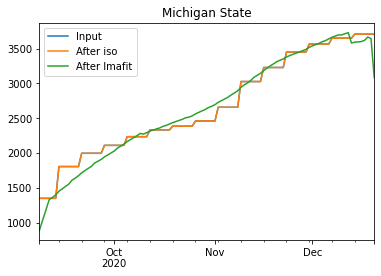

In [27]:
Michigan = pd.concat([dset.dataframe['Michigan State'], with_iso.dataframe['Michigan State'], with_comp.dataframe['Michigan State']], axis = 1)
Michigan.columns = ['Input', 'After iso', 'After lmafit']

Michigan.plot(legend=True, title = "Michigan State")

<AxesSubplot:title={'center':'Boston University'}>

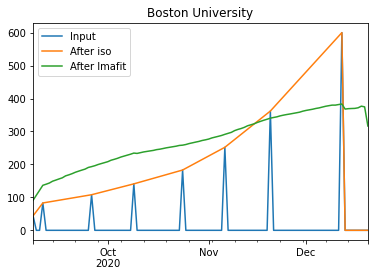

In [28]:
bu = pd.concat([dset.dataframe['Boston University'], with_iso.dataframe['Boston University'], with_comp.dataframe['Boston University']], axis = 1)
bu.columns = ['Input', 'After iso', 'After lmafit']

bu.plot(legend=True, title = 'Boston University')

<AxesSubplot:title={'center':'University of California, Los Angeles'}>

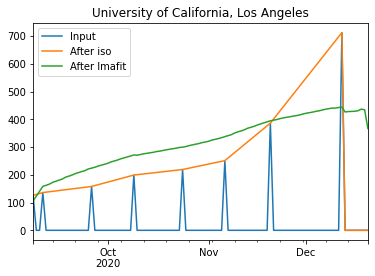

In [29]:
ucla = pd.concat([dset.dataframe['University of California, Los Angeles'], with_iso.dataframe['University of California, Los Angeles'], with_comp.dataframe['University of California, Los Angeles']], axis = 1)
ucla.columns = ['Input', 'After iso', 'After lmafit']

ucla.plot(legend=True, title = 'University of California, Los Angeles')

In [30]:
none_hidden_dict, none_percent = with_comp.is_col_inc()
print(str(none_percent) + " percent of the data points are non-increasing")

3.8461538461538463 percent of the data points are non-increasing


### Randomly hide rows

In [31]:
tests = [0, 0.05, 0.1, 0.2, 0.3, 0.4]
percent_violate= [none_percent]

In [32]:
for i in tests:
    if i == 0:
        pass
    else:
        hidden = with_iso.hide_rows(i)
        
        X3, Y3, o3 = hidden.lmafitter()

        dotted = pd.DataFrame(np.dot(X3, Y3))
        dotted.columns = hidden.dataframe.columns
        dotted.index = hidden.dataframe.index
        post_fit = mat_opr(dotted)

        post_dict, post_perc = post_fit.is_col_inc()
        percent_violate.append(post_perc)

In [33]:
print(percent_violate)

[3.8461538461538463, 4.040404040404041, 3.1914893617021276, 2.380952380952381, 4.10958904109589, 1.5822140822140822]


Text(0.5, 1.0, 'Monotonic violations with random rows hidden')

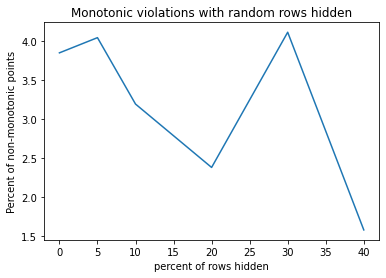

In [34]:
plt.plot([i*100 for i in tests], percent_violate)
plt.xlabel("percent of rows hidden")
plt.ylabel("Percent of non-monotonic points")
plt.title("Monotonic violations with random rows hidden")

### Randomly hide non-NYT rows

In [35]:
# drop any of the non-NYT dates
# to do so I need to find where they are:

def find_non_nyt(data_obj):
    listy = list(data_obj.dataframe.index)
    bigs = []
    for i in data_obj.dataframe.index:
        bigs.append((data_obj.dataframe.loc[i]!=0).sum())
        if (data_obj.dataframe.loc[i]!=0).sum() > 100:
            listy.remove(i)
        
    return listy

In [36]:
non_rand = find_non_nyt(dset)
print(len(non_rand))

96


In [37]:
tests = [0, 0.05, 0.1, 0.2, 0.3, 0.4]
violators= [none_percent]

In [38]:
for i in tests:
    if i == 0:
        pass
    else:
        hidden = with_iso.hide_rows(i,non_rand)
        
        X4, Y4, o4 = hidden.lmafitter()

        dotted = pd.DataFrame(np.dot(X4, Y4))
        dotted.columns = hidden.dataframe.columns
        dotted.index = hidden.dataframe.index
        post_fit = mat_opr(dotted)

        post_dict, post_perc = post_fit.is_col_inc()
        violators.append(post_perc)

In [39]:
print(violators)

[3.8461538461538463, 4.040404040404041, 4.25531914893617, 4.761904761904762, 4.10958904109589, 1.5873015873015872]


Text(0.5, 1.0, 'Monotonic violations with non NYT rows hidden')

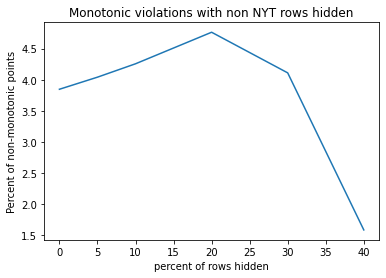

In [40]:
plt.plot([i*100 for i in tests], violators)
plt.xlabel("percent of rows hidden")
plt.ylabel("Percent of non-monotonic points")
plt.title("Monotonic violations with non NYT rows hidden")

In [42]:
with_hidden = with_iso.hide_rows(0.4, non_rand)

X5,Y5,o5 = with_hidden.lmafitter()
tog = pd.DataFrame(np.dot(X5,Y5))
tog.columns = with_hidden.dataframe.columns
tog.index = with_hidden.dataframe.index
tofin = mat_opr(tog)


<AxesSubplot:title={'center':'Boston University'}>

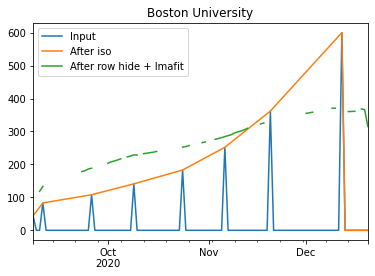

In [43]:
bu = pd.concat([dset.dataframe['Boston University'], with_iso.dataframe['Boston University'], tofin.dataframe['Boston University']], axis = 1)
bu.columns = ['Input', 'After iso', 'After row hide + lmafit']

bu.plot(legend=True, title = 'Boston University')